### Partea 1 (6p)

**Scop:** In aceasta prima parte a laboratorului dorim sa ne familiarizam cu modelele disponibile pe [HuggingFace](https://huggingface.co/) si sa le adaptam task-ului nostru.

**Task:** Zero-Shot Classsification folosind [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip).

In [1]:
# Intr-o celula separata adaugam importurile necesare
# Daca acestea nu functioneaza putem adauga o noua celula si "!pip install"

from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

2025-04-12 08:43:34.290170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744447414.517673      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744447414.588013      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Incarcarea modelului
model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
# Si a processor-ului
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

# Citirea imaginii de tip URL
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

In [3]:
# Descrierile textuale
texts = ["a photo of 2 cats", "a photo of 2 dogs"]
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

# Inferenta
with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image)
print(f"{probs[0][0]:.1%} that image is '{texts[0]}'") # Probabilitatile extrase

31.9% that image is 'a photo of 2 cats'


#### Warm-up (0.5p)

Extrage si prabilitatea celei de-a doua descrieri vis-a-vis de poza de input. Cum comentezi rezultatul obtinut?

In [4]:
print(probs.shape)
print(f"{probs[0][1]:.1%} that image is '{texts[1]}'")

torch.Size([1, 2])
0.0% that image is 'a photo of 2 dogs'


There is no chance that the image has any correlation with the description: "a photo of 2 dogs"

#### Compara cu CLIP (0.5p)


<img src="https://drive.google.com/uc?id=1nxy7wLRqVi_I1f9pNX8TViIpn88i9rR1">

Adapteaza codul de mai sus astfel incat sa vezi care sunt cele 4 tipuri de probabilitati pe care SigCLIP le scoate pentru cele 4  tipuri de clase din imaginea de mai sus.



In [5]:
texts = ["a banana", "the Eiffel tower", "2 cars", "the starbucks logo"]
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image)

for i in range(len(texts)):
    print(f"{probs[0][i]:.6%} that image is '{texts[i]}'")

0.000041% that image is 'a banana'
0.000036% that image is 'the Eiffel tower'
0.002223% that image is '2 cars'
0.000001% that image is 'the starbucks logo'


#### Custom Dataset si functie de citire (2p)

**a)** Creaza o functie care iti permite sa citesti imagini salvate fie pe disk, fie URLs.


In [6]:
def read_image(input_image_path):
    img = None
    
    try:
        img = Image.open(requests.get(input_image_path, stream=True).raw)
    except:
        img = Image.open(input_image_path)
        
    return img

**b)** Alege 10 imagini diferite atat ca continut cat si ca sursa (local sau URL). Pentru fiecare dintre imagini alege 3 label-uri potentiale. Cum?

**Exemplu:** Sa spunem ca folosim o imagine cu o pisicuta. 2 dintre label-uri vor fi apropiate dpdv semantic subiectului `["an orange cat", "cutie purr cat"]`, iar ultimul va fi departat `["a bus"]`.

_Hint:_ Te poti folosi de o structura de date (exemplu dictionar) care sa iti permita sa retii maparea imagine ~ labels.

Salveaza aceasta mapare intr-o variabila, te va ajuta in exercitiul urmator!

In [7]:
image_paths = [
    "http://images.cocodataset.org/val2017/000000039769.jpg", 
    "/kaggle/input/realistic-image-classification/train/00094a5d365ffafe1334336ffd05f043e8222c6c3a5182732317f37556c4538d.png",
    "/kaggle/input/realistic-image-classification/train/001d4260b1e0199f044881f3d4ccaaf4ec8c24e8faf599b1b77d6c3beed3fc3c.png",
    "http://images.cocodataset.org/val2017/000000037777.jpg",
    "/kaggle/input/realistic-image-classification/train/005c7c43bd99198e71ebace293be5c0a87bf377973590dbef97762a7231306fc.png",
    "http://images.cocodataset.org/val2017/000000480985.jpg",
    "http://images.cocodataset.org/val2017/000000296649.jpg",
    "/kaggle/input/realistic-image-classification/train/00d04e47bd99dc9c4296fb219c2f86d625b70e757ad862e589f8617e1287616e.png",
    "/kaggle/input/realistic-image-classification/train/01059f087db8678cc2e7fec1c06e0af2f08a9e3a51127990630d17b2a0996644.png",
    "http://images.cocodataset.org/val2017/000000386912.jpg"
]
labels = [
    ["two black cats", "two white cats", "a football"],
    ["a blue horse", "muscular horse", "beach view"],
    ["a girl playing baseball", "a guy hitting a ball", "an orange banana"],
    ["a colorful living room", "fruits on a table", "a dark alley"],
    ["a steak on a plate", "good looking food", "an elephant"],
    ["fully black motocycle", "front view of a moped", "a very fast car"],
    ["busy street in america", "green buildings", "mountain view"],
    ["a small vegetable", "green vegetable", "a big house"],
    ["cute looking dogs", "white dog", "an airplane"],
    ["man using computer", "a girl writing", "a car"]
]

small_dataset = {
    image_paths[i]: labels[i] for i in range(len(image_paths))
}

#### Zero-Shot Classification simplificat (2p)

In scheletul de mai jos vedem cum putem incarca direct un pipeline de clasificare zero-shot. Tot ce ramane de facut este sa automatizam procesul de inferenta astfel incat el sa treaca prin fiecare imagine din dataset-ul costum si sa acorde scores pentru label-urile candidat.

In [8]:
from transformers import pipeline
from PIL import Image
import requests

# load pipe
image_classifier = pipeline(task="zero-shot-image-classification", model="google/siglip-base-patch16-224")

# load image: [Aceasta este zona in care read_image() de mai sus va fi folosita]
for image_path, labels in small_dataset.items():
    image = read_image(image_path)
    # inference
    # [Aceasta este zona in care vrem sa scoatem predictii pentru fiecare imagine si label-urile aferente]
    outputs = image_classifier(image, candidate_labels=labels)
    outputs = [{"score": round(output["score"], 4), "label": output["label"] } for output in outputs]
    print(outputs)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


[{'score': 0.0017, 'label': 'two black cats'}, {'score': 0.0005, 'label': 'two white cats'}, {'score': 0.0, 'label': 'a football'}]
[{'score': 0.0082, 'label': 'a blue horse'}, {'score': 0.0018, 'label': 'muscular horse'}, {'score': 0.0, 'label': 'beach view'}]
[{'score': 0.3331, 'label': 'a guy hitting a ball'}, {'score': 0.0341, 'label': 'a girl playing baseball'}, {'score': 0.0, 'label': 'an orange banana'}]
[{'score': 0.0, 'label': 'a colorful living room'}, {'score': 0.0, 'label': 'fruits on a table'}, {'score': 0.0, 'label': 'a dark alley'}]
[{'score': 0.0005, 'label': 'good looking food'}, {'score': 0.0004, 'label': 'a steak on a plate'}, {'score': 0.0, 'label': 'an elephant'}]
[{'score': 0.0235, 'label': 'front view of a moped'}, {'score': 0.005, 'label': 'fully black motocycle'}, {'score': 0.0001, 'label': 'a very fast car'}]
[{'score': 0.0001, 'label': 'green buildings'}, {'score': 0.0, 'label': 'busy street in america'}, {'score': 0.0, 'label': 'mountain view'}]
[{'score': 0

#### Validare (1p)

* Defineste human-confidence score-ul tau pentru label-ul pe care il consideri cel mai relavant din seria de 3 label-uri posibile ale unei imagini.

**Exemplu:**

<img src="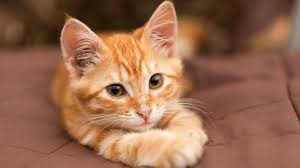
">

`["an orange cat", "cutie purr cat", "a bus"]`

Pentru poza de mai sus setam un scor de 0.9 pentru label-ul de referinta `"an orange cat"` (Acesta este GT score-ul setat de noi).

* Comparam matematic daca diferenta dintre scorul prezis de SigClip si GT score-ul nostru **NU** este mai mare de 20%.

* Insumam matematic si vedem pentru cate din cele 10 imagini aceasta diferenta este aplicabila.


Resurse:

[SigLIP huggingface documentation](https://huggingface.co/docs/transformers/en/model_doc/siglip)

[Huggingface dataset](https://huggingface.co/docs/datasets/en/loading)



All scores are very low, thus none of them reaching my GT score.

## Partea a2a: Image Captioning (4p)

In [2]:
# Imports necesare pt data
import pandas as pd
from PIL import Image
import io
import ast
import numpy as np

### Optiunea 1 de incarcare a datelor

`Pokemon Images and Text Descriptions` este Datasetul folosit pentru acest task si poate fi descarcat de pe [Kaggle](https://www.kaggle.com/datasets/thedevastator/pokemon-llava-images-and-text-descriptions). Ne intereseaza sa extragem `train.csv` file pe care apoi il putem incarca in Google Colab(Procesul de load al datelor va dura cateva minute).

_Obs:_ In suportul de laborator am folosit `train_small.csv`, o versiune care contine 70 de random samples extrase din `train.csv`.

Daca vrei sa descarci si incarci `train_small.csv` il gasesti [aici](https://drive.google.com/file/d/1oxCpIQvNZ6FnjhaTUayw7kz8MqU2pfA0/view?usp=sharing).

In [3]:
df = pd.read_csv(io.BytesIO(open("/kaggle/input/pokemon-llava-images-and-text-descriptions/train.csv", "rb").read()))

In [4]:
df.head(2)

,image,text
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,A cartoon drawing of a green Pokemon with a le...
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,A cartoon character with a red face and a gree...


### Optiunea 2 de incarcare a datelor

Daca aveti tokens de autentificare si acces pe huggingface, puteti folosi direct dataset-ul Pokemon. Cod util:

Install rapid cu:

```bash
!pip install -q datasets
```

```python
# Partea aceasta este necesara pentru autentificare
from huggingface_hub import notebook_login

notebook_login()

# Pokemonii si descrierile lor sunt salvati in variabila dataset
from datasets import load_dataset
dataset = load_dataset("lambdalabs/pokemon-blip-captions")
```

_Hint:_ [Resursa Suport pentru acest task si ghidare catre outputul dorit](https://huggingface.co/docs/transformers/main/en/tasks/image_captioning)

In [12]:
# !pip install datasets
# Am comentat linia de mai sus; Decomenteaz-o daca vrei sa mergi pe Optiunea 2
# Este doar un demo: Poti lua codul din markdown si pune intr-o celula Colab de Cod ;)

### Optiunea 3 de incarcare a datelor

Poti lucra tot acest laborator local daca resursele iti permit, si atunci doar vei citi de pe disk `train.csv` punand path-ul corect si folosindu-te de codul de la `Optiunea 1` pentru incarcare a datelor intr-un dataframe.

### Citirea si Vizualizarea datelor

In [5]:
# Observam ca in df avem 2 coloane care mentin perechile imagine ~ text
df.columns

Index(['image', 'text'], dtype='object')

In [6]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

# Acest helper function ne ajuta sa vizualizam imaginile si caption-urile aferenete

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

In [7]:
# Acest helper function ne permite sa decodificam imaginile din df
def convert_bytes_to_Image(byte_array) :
    return Image.open(io.BytesIO((ast.literal_eval(byte_array)['bytes'])))

In [8]:
# Iar aici aplicam functia de mai sus
sample_images_to_visualize = [np.array(convert_bytes_to_Image(df["image"][i])) for i in range(5)]

In [9]:
df['text'][0]

'A cartoon drawing of a green Pokemon with a leaf on its back.'

In [11]:
sample_captions = [df["text"][i] for i in range(5)]

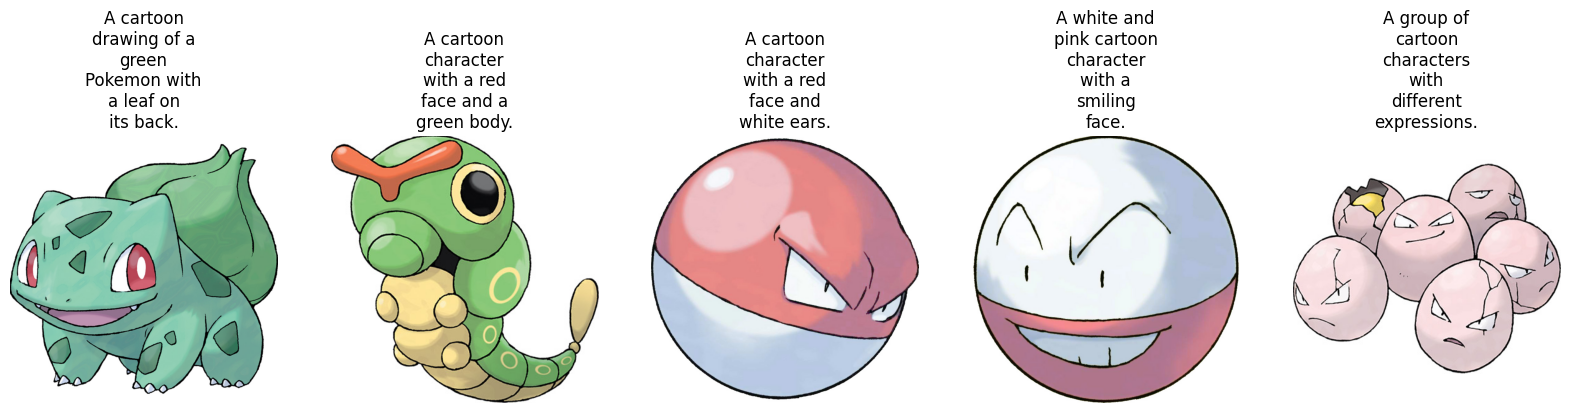

In [12]:
plot_images(sample_images_to_visualize, sample_captions)

In [13]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [14]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint).cuda()

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [15]:
test_inference_image = convert_bytes_to_Image(df["image"][1])

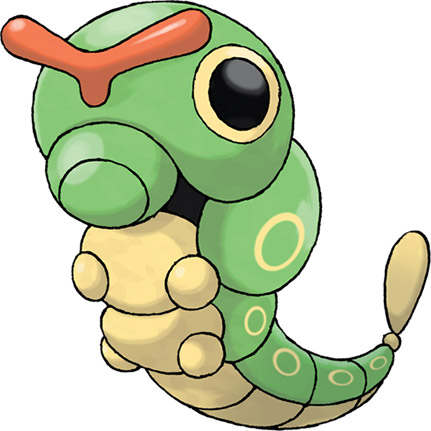

In [16]:
test_inference_image

In [17]:
import torch

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=test_inference_image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [26]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

cartoon green caterpillar with a red cap on a white background vector art illustration


In [27]:
print('Ground-truth caption: ', sample_captions[0])
print('Descrierea generata:', generated_caption)

Ground-truth caption:  A cartoon drawing of a green Pokemon with a leaf on its back.
Descrierea generata: cartoon green caterpillar with a red cap on a white background vector art illustration


### Testeaza modelul (2p)

Similar exemplului de mai sus, alege 20 de perechi de Pokemoni si descrierile lor si verifica daca modelul ales ofera captions care match-uiesc descrierile din GT. Ce observi? Daca ar fi sa faci o Validare numerica similara exemplului din `Partea 1`, cate din imagini si descrierile lor ar face un match folosind human supervision-ul tau?

In [28]:
test_images_20 = [np.array(convert_bytes_to_Image(df["image"][i])) for i in range(20)]
test_labels_20 = [df["text"][i] for i in range(20)]

inputs = processor(images=test_images_20, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)

for i in range(len(test_labels_20)):
    print(f"Index: {i}")
    print(test_labels_20[i])
    print(generated_captions[i])
    print()

Index: 0
A cartoon drawing of a green Pokemon with a leaf on its back.
how to draw a cartoon character step by step

Index: 1
A cartoon character with a red face and a green body.
cartoon green caterpillar with a red cap on a white background vector art illustration

Index: 2
A cartoon character with a red face and white ears.
illustration of a ball with a face

Index: 3
A white and pink cartoon character with a smiling face.
a ball with a smile

Index: 4
A group of cartoon characters with different expressions.
cartoon of a happy face

Index: 5
A cartoon character with a big smile and a big green leaf on its head.
cute cartoon of a cute little monster

Index: 6
A cartoon character with a skeleton head and a white helmet.
digital art selected for the #

Index: 7
A cartoon character is holding a bone in its mouth.
a little bear in a hat

Index: 8
A cartoon character with a large foot and claws.
a cartoon of a monster

Index: 9
A cartoon character is wearing a blue dress and boxing glove

The ones chosen by me:
* 1
* 15
* 16

In total only 3 generated captions made the cut out of 20.

### Fine-tuneaza modelul (2p)

Foloseste-te de [Resursa Suport pentru acest task si ghidare catre outputul dorit](https://huggingface.co/docs/transformers/main/en/tasks/image_captioning) si adapteaza procesul de fine-tunare pe datele tale.

_Obs:_ Daca ai ales Optiunea 1 sau 3 de incarcare a datelor, poti folosi `train.csv` ca input data si pe el sa il imparti in train ~ test (Aici depinde de cum ai facut load-ul datelor tale).

**Foarte important:** Grija la data leakage❗❗❗ Pentru a testa modelul dupa fine-tune trebuie sa folosim date cu pokemoni dintr-o distributie pe care modelul NU a vazut-o la antrenare.

In [22]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [25]:
!pip install fsspec==2024.10.0

In [24]:
!pip install nvidia-cublas-cu12==12.4.5.8
!pip install nvidia-cudnn-cu12==9.1.0.70
!pip install nvidia-cufft-cu12==11.2.1.3
!pip install nvidia-curand-cu12==10.3.5.147
!pip install nvidia-cusolver-cu12==11.6.1.9
!pip install nvidia-cusparse-cu12==12.3.1.170
!pip install nvidia-nvjitlink-cu12==12.4.127

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-cublas-cu12
    Found existing installation: nvidia-cublas-cu12 12.8.4.1
    Uninstalling nvidia-cublas-cu12-12.8.4.1:
      Successfully uninstalled nvidia-cublas-cu12-12.8.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-curand-cu12 10.3.9.90 w

In [26]:
!pip install evaluate -q
!pip install jiwer -q

In [56]:
import gc
import torch 

gc.collect()
torch.cuda.empty_cache()

In [27]:
from sklearn.model_selection import train_test_split
from transformers import AutoProcessor
from datasets import Dataset

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.1, random_state=42)

processor = AutoProcessor.from_pretrained(checkpoint)

def preprocess(example_batch):
    images = [convert_bytes_to_Image(img) for img in example_batch["image"]]
    captions = example_batch["text"]
    
    inputs = processor(images=images, text=captions, padding="max_length", truncation=True, return_tensors="pt")
    
    inputs["input_ids"] = [ids.tolist() for ids in inputs["input_ids"]]
    inputs["attention_mask"] = [mask.tolist() for mask in inputs["attention_mask"]]
    inputs["labels"] = inputs["input_ids"]
    
    return inputs

train_df = Dataset.from_pandas(train_df)
train_df = train_df.map(preprocess, batched=True, batch_size=16)

valid_df = Dataset.from_pandas(valid_df)
valid_df = valid_df.map(preprocess, batched=True, batch_size=16)

test_df = Dataset.from_pandas(test_df)
test_df = test_df.map(preprocess, batched=True, batch_size=16)

Map:   0%|          | 0/666 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

In [28]:
print(train_df.features)

{'image': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [29]:
from transformers import AutoModelForCausalLM
from evaluate import load
import torch
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

from transformers import logging
logging.set_verbosity_info()


checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint)


wer = load("wer")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

print("Initialized...")

model_name = checkpoint.split("/")[1]
training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=1,
    save_strategy="steps",
    save_steps=50,
    logging_steps=1,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    remove_unused_columns=False,
)

print("Starting Training...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=valid_df,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
)

trainer.train()
print("Finished Training...")

print("Starting Inference...")
inputs = processor(images=test_df["image"], return_tensors="pt").to(model.device)
pixel_values = inputs.pixel_values
print("Finished Inference...")

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)
print(*generated_captions, sep="\n")

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--git-base/snapshots/1f7fe8444292beb4a259e3a5b6eba440cd5999d4/preprocessor_config.json
loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--git-base/snapshots/1f7fe8444292beb4a259e3a5b6eba440cd5999d4/preprocessor_config.json
Image processor CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "GitProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

loading file vocab.txt from cache at /root/.cache/huggingface/h

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Initialized...
Starting Training...


Using auto half precision backend
***** Running training *****
  Num examples = 666
  Num Epochs = 50
  Instantaneous batch size per device = 2
  Training with DataParallel so batch size has been adjusted to: 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 1,000
  Number of trainable parameters = 176,619,066
vision_config is None. initializing the GitVisionConfig with default values.
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

KeyboardInterrupt: 